<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#-Комментарий-ревьюера" data-toc-modified-id="-Комментарий-ревьюера-5"><span class="toc-item-num">5&nbsp;&nbsp;</span> Комментарий ревьюера</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [33]:
#Загрузка библитек
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split

from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.dummy import DummyClassifier

In [2]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [5]:
data.isna().sum()

num_orders    0
dtype: int64

In [6]:
#Проверим упорядочен ли наш index
print(data.index.is_monotonic)

True


In [7]:
# Ресемплирование по одному часу
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
data.index.min(), data.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:00:00'))

## Анализ

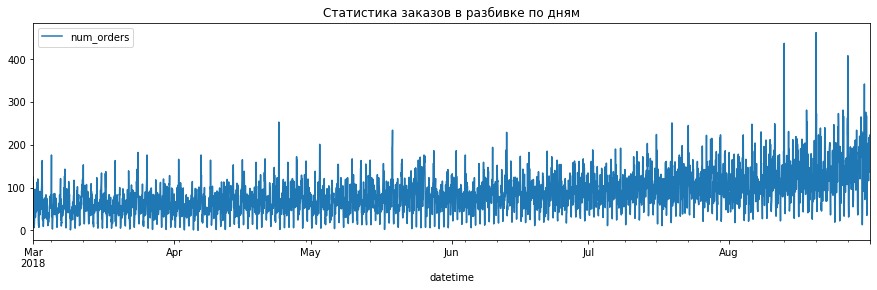

In [9]:
#Посмотрим на статистику заказов в разбивке по дням
data.plot(title='Cтатистика заказов в разбивке по дням', figsize=(15,4))

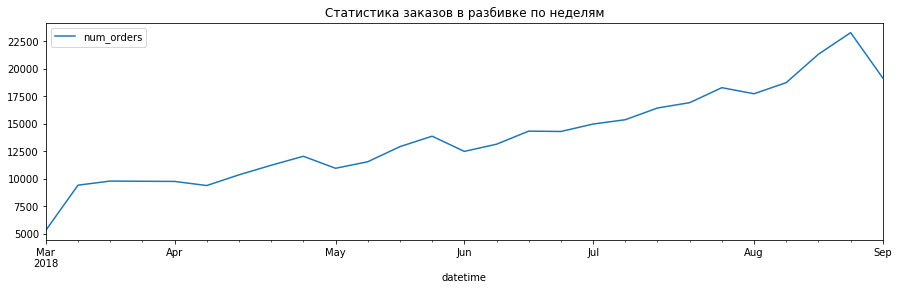

In [10]:
#Посмотрим на статистику заказов в разбивке по неделям
week = data.resample('1W').sum()
week.plot(title='Cтатистика заказов в разбивке по неделям', figsize=(15,4))

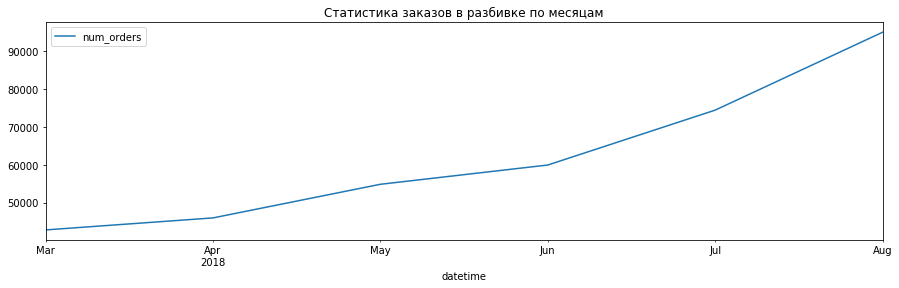

In [11]:
#Посмотрим на статистику заказов в разбивке по месецам
month = data.resample('1M').sum()
month.plot(title='Cтатистика заказов в разбивке по месяцам', figsize=(15,4))

In [12]:
#data['rolling_mean'] = data['num_orders'].shift().rolling(12).mean()
#data['std'] = data['num_orders'].shift().rolling(12).std()


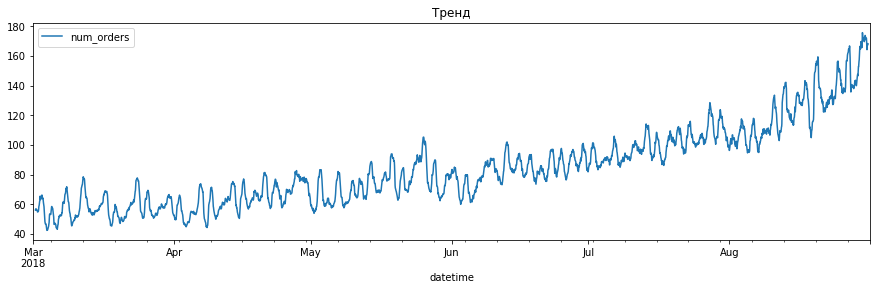

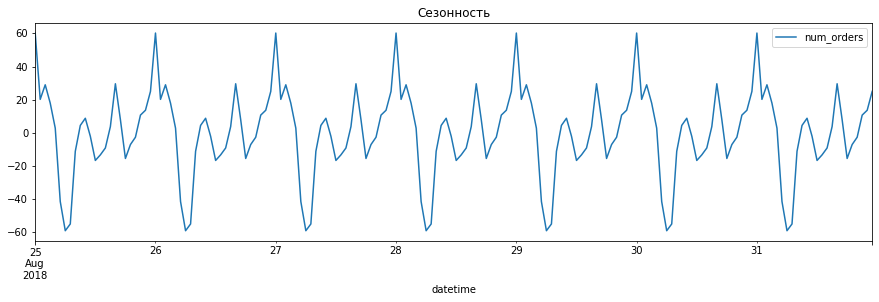

In [13]:
#Построим графики тренда, сезона
#data = data.dropna()
decomposed_data = seasonal_decompose(data)
decomposed_data.trend.plot(title='Тренд', figsize=(15,4))
decomposed_data.seasonal.tail(24*7).plot(title='Сезонность', figsize=(15,4))



**Вывод**
1. На графике "Тренд" можно увидеть, что количество заказов постепенно увеличивается.
2. На графике сезонность разбитое на неделю видно, как количество заказов утром меньше, чем вечером

## Обучение

**Создание признаков**

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

**Функция RMSE**

In [15]:
def rmse(target, predictions):
    mse = mean_squared_error(target, predictions)
    rmse = sqrt(mse)
    return rmse

In [16]:
make_features(data, 24, 24)
data.describe()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
count,4416.000000,4416.0,4416.000000,4416.000000,4416.000000,4415.000000,4414.000000,4413.000000,4412.000000,4411.000000,...,4400.000000,4399.000000,4398.000000,4397.000000,4396.000000,4395.000000,4394.000000,4393.000000,4392.000000,4392.000000
mean,84.422781,2018.0,5.505435,15.836957,3.005435,84.395470,84.364069,84.347156,84.331369,84.319655,...,84.095227,84.103887,84.115052,84.116443,84.074613,84.071217,84.038006,84.012975,83.969262,84.257153
std,45.023853,0.0,1.713306,8.855229,1.990684,44.992356,44.949043,44.940088,44.932942,44.931299,...,44.733738,44.735135,44.734091,44.739084,44.658098,44.662612,44.613388,44.587597,44.498432,26.308289
min,0.000000,2018.0,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.375000
25%,54.000000,2018.0,4.000000,8.000000,1.000000,54.000000,54.000000,54.000000,54.000000,54.000000,...,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,63.666667
50%,78.000000,2018.0,5.500000,16.000000,3.000000,78.000000,78.000000,78.000000,78.000000,78.000000,...,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,79.708333
75%,107.000000,2018.0,7.000000,23.250000,5.000000,107.000000,107.000000,107.000000,107.000000,107.000000,...,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,99.802083
max,462.000000,2018.0,8.000000,31.000000,6.000000,462.000000,462.000000,462.000000,462.000000,462.000000,...,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,176.916667


**Комментарий**

Рассчитал функцию с парараметрами (data, 24, 24) с разбиением по дням. Благодаря, изменению на 24 улучшилось RMSE.

**Разбивка датасета на обучающую и тестовую выборку**

In [17]:
data = data.dropna()

In [18]:
# Опредлим признаки и целевой признак 
X = data.drop('num_orders', axis=1)
y = data['num_orders']


#разделим датасет на обучающую и тестовую выборку размеров 60 на 40

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train_valid, X_valid, y_train_valid, y_valid = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)




In [19]:
#Размеры обучающей и тестовой выборки
print('Размер обучающей выборки: {} объектов, {} признаков'.format(X_train.shape[0], X_train.shape[1]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(X_test.shape[0], X_test.shape[1]))
print('Размер валидационной выборки: {} объектов, {} признаков'.format(X_train_valid.shape[0], X_train_valid.shape[1]))
print('Размер валидационной тестовой выборки: {} объектов, {} признаков'.format(X_valid.shape[0], X_valid.shape[1]))

Размер обучающей выборки: 3513 объектов, 29 признаков
Размер тестовой выборки: 879 объектов, 29 признаков
Размер валидационной выборки: 439 объектов, 29 признаков
Размер валидационной тестовой выборки: 440 объектов, 29 признаков


In [20]:
#Проверим правильно ли расположены временные даннные, нельзя допустить в обучающую выборку данные из будущего
display(X_valid.head())
display(X_train_valid.head())

,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 16:00:00,2018,8,13,0,175.0,102.0,119.0,92.0,144.0,156.0,...,160.0,185.0,118.0,135.0,98.0,82.0,78.0,115.0,153.0,139.541667
2018-08-13 17:00:00,2018,8,13,0,144.0,175.0,102.0,119.0,92.0,144.0,...,273.0,160.0,185.0,118.0,135.0,98.0,82.0,78.0,115.0,139.166667
2018-08-13 18:00:00,2018,8,13,0,152.0,144.0,175.0,102.0,119.0,92.0,...,437.0,273.0,160.0,185.0,118.0,135.0,98.0,82.0,78.0,140.708333
2018-08-13 19:00:00,2018,8,13,0,104.0,152.0,144.0,175.0,102.0,119.0,...,168.0,437.0,273.0,160.0,185.0,118.0,135.0,98.0,82.0,141.791667
2018-08-13 20:00:00,2018,8,13,0,91.0,104.0,152.0,144.0,175.0,102.0,...,143.0,168.0,437.0,273.0,160.0,185.0,118.0,135.0,98.0,142.166667


,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-07-26 09:00:00,2018,7,26,3,80.0,39.0,21.0,83.0,131.0,141.0,...,121.0,134.0,119.0,95.0,99.0,83.0,93.0,95.0,122.0,105.125000
2018-07-26 10:00:00,2018,7,26,3,138.0,80.0,39.0,21.0,83.0,131.0,...,68.0,121.0,134.0,119.0,95.0,99.0,83.0,93.0,95.0,105.791667
2018-07-26 11:00:00,2018,7,26,3,142.0,138.0,80.0,39.0,21.0,83.0,...,137.0,68.0,121.0,134.0,119.0,95.0,99.0,83.0,93.0,107.750000
2018-07-26 12:00:00,2018,7,26,3,86.0,142.0,138.0,80.0,39.0,21.0,...,111.0,137.0,68.0,121.0,134.0,119.0,95.0,99.0,83.0,107.458333
2018-07-26 13:00:00,2018,7,26,3,102.0,86.0,142.0,138.0,80.0,39.0,...,110.0,111.0,137.0,68.0,121.0,134.0,119.0,95.0,99.0,108.250000


In [21]:
print(X_train_valid.index.is_monotonic)

print(X_train_valid.index.min(), X_train_valid.index.max())
print(X_valid.index.min(), X_valid.index.max())


True
2018-07-26 09:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


**LinearRegression**

In [22]:
results = []

model = LinearRegression()
model.fit(X_train,y_train)
pred_train = model.predict(X_train_valid)
results.append({'Модель': 'LinearRegression', 
                'RMSE': rmse(pred_train, y_train_valid)})


**CatBoostRegressor**

In [23]:
for iteration in range(10, 101, 20):
    
    for depth in range(5, 11, 2):
    
        model_cbr = CatBoostRegressor(random_state=123, iterations=iteration, loss_function='RMSE', depth=depth)

        model_cbr.fit(X_train,y_train)
        predictions_cbr = model_cbr.predict(X_train_valid)
        RMSE = rmse(predictions_cbr, y_train_valid)
    
        results.append({'Модель': 'CatBoostRegressor', 
                        'Параметры': {'random_state':123, 
                                      'iterations': iteration, 
                                      'loss_function': 'RMSE', 
                                      'depth': depth},
                        'RMSE': RMSE})

0:	learn: 35.2546509	total: 55.1ms	remaining: 496ms
1:	learn: 34.7923901	total: 58.5ms	remaining: 234ms
2:	learn: 34.3982104	total: 129ms	remaining: 302ms
3:	learn: 34.0038213	total: 139ms	remaining: 209ms
4:	learn: 33.6019893	total: 150ms	remaining: 150ms
5:	learn: 33.2258478	total: 239ms	remaining: 159ms
6:	learn: 32.8785310	total: 246ms	remaining: 105ms
7:	learn: 32.5342387	total: 254ms	remaining: 63.5ms
8:	learn: 32.2048990	total: 331ms	remaining: 36.7ms
9:	learn: 31.8788970	total: 338ms	remaining: 0us
0:	learn: 35.2540470	total: 11.1ms	remaining: 100ms
1:	learn: 34.7924591	total: 72.9ms	remaining: 292ms
2:	learn: 34.3330380	total: 82.2ms	remaining: 192ms
3:	learn: 33.9016030	total: 158ms	remaining: 238ms
4:	learn: 33.4788608	total: 263ms	remaining: 263ms
5:	learn: 33.0811599	total: 273ms	remaining: 182ms
6:	learn: 32.7003066	total: 361ms	remaining: 155ms
7:	learn: 32.3483377	total: 373ms	remaining: 93.4ms
8:	learn: 31.9762295	total: 457ms	remaining: 50.8ms
9:	learn: 31.6079076	tot

**LGBMRegressor**

In [24]:
estimators = [50,100,200,300]
forleaves = [2,5,7,12]
model__max_depth = [-1,10,20,25]
model__learning_rate = [0.08,0.1,0.12,0.16]

for estim, leaves, depth, rate in zip(estimators, forleaves, model__max_depth, model__learning_rate):
    model_lgbm = lgb.LGBMRegressor(n_estimators=estim, num_leaves=leaves, 
                                   max_depth=depth, learning_rate=rate)
    model_lgbm.fit(X_train,y_train)
    predictions_lgbm = model_lgbm.predict(X_train_valid)
    results.append({'Модель': 'LGBMRegressor', 
                    'Параметры': {estim, leaves, depth, rate},  
                    'RMSE': rmse(predictions_lgbm, y_train_valid)})

**Lasso**

In [25]:
model_lss = Lasso(random_state=123,alpha=1)
model_lss.fit(X_train,y_train)
predictions_lss = model_lss.predict(X_train_valid)
results.append({'Модель': 'Lasso',
                 'RMSE': rmse(predictions_lss, y_train_valid)})            

In [26]:
pd.DataFrame(results).style.highlight_min(color = 'lightgreen', axis = 0)

,Модель,RMSE,Параметры
0,LinearRegression,34.152,nan
1,CatBoostRegressor,53.3886,"{'random_state': 123, 'iterations': 10, 'loss_function': 'RMSE', 'depth': 5}"
2,CatBoostRegressor,52.8661,"{'random_state': 123, 'iterations': 10, 'loss_function': 'RMSE', 'depth': 7}"
3,CatBoostRegressor,53.141,"{'random_state': 123, 'iterations': 10, 'loss_function': 'RMSE', 'depth': 9}"
4,CatBoostRegressor,46.8918,"{'random_state': 123, 'iterations': 30, 'loss_function': 'RMSE', 'depth': 5}"
5,CatBoostRegressor,46.0426,"{'random_state': 123, 'iterations': 30, 'loss_function': 'RMSE', 'depth': 7}"
6,CatBoostRegressor,46.1516,"{'random_state': 123, 'iterations': 30, 'loss_function': 'RMSE', 'depth': 9}"
7,CatBoostRegressor,43.107,"{'random_state': 123, 'iterations': 50, 'loss_function': 'RMSE', 'depth': 5}"
8,CatBoostRegressor,42.0164,"{'random_state': 123, 'iterations': 50, 'loss_function': 'RMSE', 'depth': 7}"
9,CatBoostRegressor,42.06,"{'random_state': 123, 'iterations': 50, 'loss_function': 'RMSE', 'depth': 9}"


**Вывод**

Лучший показатель RMSE на обучающей выборке - LGBMRegressor, но также будет тестировать на Lasso и CatBoostRegressor.

## Тестирование

**Тестирование на LGBMRegressor**

In [27]:
model = lgb.LGBMRegressor(n_estimators=200, num_leaves=7, max_depth=20, 
                          learning_rate=0.12, random_state=123)
model.fit(X_train, y_train)
predictions = model.predict(X_valid)
print('RMSE на тестовой выборке:', rmse(predictions, y_valid))

RMSE на тестовой выборке: 53.227470687715936


**Комментарий**

Все меняется!!! Lasso оказалось лучше)

**Тестирование на Lasso**

In [28]:
model_lss = Lasso(random_state=123,alpha=1)
model_lss.fit(X_train,y_train)
predictions_lss = model_lss.predict(X_valid)
print('RMSE на тестовой выборке:', rmse(predictions_lss, y_valid))

RMSE на тестовой выборке: 45.62327981612917


Тестирование на Lasso показало RMSE<48.

**Тестирование на CatBoostRegressor**

In [29]:
model_cbr = CatBoostRegressor(random_state=123, iterations=90, loss_function='RMSE', depth=12)

model_cbr.fit(X_train,y_train)
predictions_cbr = model_cbr.predict(X_valid)
RMSE = rmse(predictions_cbr, y_valid)
print('RMSE на тестовой выборке:', RMSE)
    

0:	learn: 35.2350794	total: 719ms	remaining: 1m 3s
1:	learn: 34.7467327	total: 1.23s	remaining: 54.3s
2:	learn: 34.3039718	total: 1.82s	remaining: 52.9s
3:	learn: 33.9137116	total: 2.33s	remaining: 50s
4:	learn: 33.5170050	total: 2.93s	remaining: 49.7s
5:	learn: 33.1189397	total: 3.52s	remaining: 49.4s
6:	learn: 32.7181405	total: 4.03s	remaining: 47.8s
7:	learn: 32.3784859	total: 4.62s	remaining: 47.3s
8:	learn: 32.0246499	total: 5.21s	remaining: 46.9s
9:	learn: 31.6938439	total: 5.82s	remaining: 46.5s
10:	learn: 31.3145145	total: 6.41s	remaining: 46s
11:	learn: 30.9726537	total: 6.92s	remaining: 45s
12:	learn: 30.6308177	total: 7.51s	remaining: 44.5s
13:	learn: 30.3043448	total: 8.1s	remaining: 44s
14:	learn: 29.9668532	total: 8.7s	remaining: 43.5s
15:	learn: 29.6528092	total: 9.21s	remaining: 42.6s
16:	learn: 29.3431611	total: 9.8s	remaining: 42.1s
17:	learn: 29.0390573	total: 10.4s	remaining: 41.6s
18:	learn: 28.7593817	total: 11s	remaining: 41.1s
19:	learn: 28.4725039	total: 11.5s	

Рассматривал другие модели на тестовой выборке для расчета RMSE, как оказаолось они все больше 48.

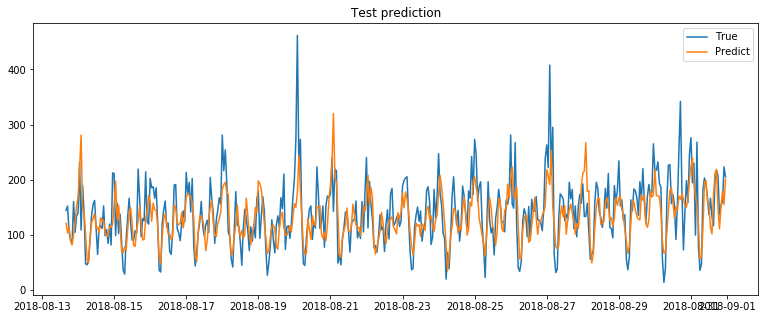

In [30]:

plt.figure(figsize=(13, 5))

plt.plot(y_valid, label='True')
plt.plot(y_valid.index, predictions_lss, label='Predict')

plt.title('Test prediction')
plt.legend()
plt.show()


Как видно по графику, наша модель достаточно хорошо попадает в реальные заказы погрешностью, особенно в пиковых значениях.

**Тестирование на DummyClassifier**

In [48]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)
predictions_clf = dummy_clf.predict(X_valid)
RMSE = rmse(predictions_cbr, y_valid)
print('RMSE на тестовой выборке:', RMSE)
    

RMSE на тестовой выборке: 64.24685230910153


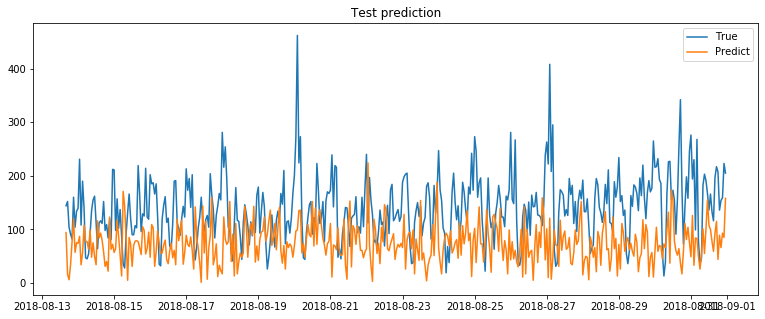

In [49]:
plt.figure(figsize=(13, 5))

plt.plot(y_valid, label='True')
plt.plot(y_valid.index, predictions_clf, label='Predict')

plt.title('Test prediction')
plt.legend()
plt.show()


Графики сильно отличаются по DummyClassifier.

**Вывод**

Для прогнозирования временного ряда были выполнены следующие шаги:

- Данные ресемплированы по 1 часу
- Проведена генерация признаков
- Поиском по сетке искалась лучшая модель с лучшими гиперпараметрами из: 'CatBoostRegressor', 'LGBMRegressor', 'LinearRegression', 'Lasso'
- Данные всех моделей сведены в 1 таблицу
- В качестве лучшей выбрана 'Lasso'
- Достигнутое значение метрики RMSE на тестовой выборке: ~46